In [29]:
import pyspark
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.jars", "/home/hduser/mysql-connector-java-5.1.47/mysql-connector-java-5.1.47.jar") \
    .master("local").appName("PySpark_MySQL_test").getOrCreate()

In [12]:
conn = pymysql.connect(
        host='localhost',
        user='root', 
        password = "",
        db='etl',
        )
      
cur = conn.cursor()
      
    # Select query
cur.execute("DESCRIBE crypto")
output = cur.fetchall()
      
for i in output:
    print(i)
      
    # To close the connection

('ID', 'int(11)', 'NO', 'PRI', None, 'auto_increment')
('Name', 'varchar(300)', 'NO', '', None, '')
('Symbol', 'varchar(300)', 'NO', '', None, '')
('Date', 'date', 'NO', '', None, '')
('High', 'double', 'NO', '', None, '')
('Low', 'double', 'NO', '', None, '')
('Open', 'double', 'NO', '', None, '')
('Close', 'double', 'NO', '', None, '')
('Volume', 'double', 'NO', '', None, '')
('Marketcap', 'double', 'NO', '', None, '')


In [13]:
pdf = pd.read_sql("SELECT * FROM crypto", con=conn)

In [44]:
pdf

,ID,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,datetime
0,5756,Dogecoin,DOGE,2013-12-16,0.001,0.000,0.000,0.000,0.000000e+00,1.509085e+06,2013-12-16
1,5757,Dogecoin,DOGE,2013-12-17,0.000,0.000,0.000,0.000,0.000000e+00,2.169688e+06,2013-12-17
2,5758,Dogecoin,DOGE,2013-12-18,0.000,0.000,0.000,0.000,0.000000e+00,3.188943e+06,2013-12-18
3,5759,Dogecoin,DOGE,2013-12-19,0.002,0.000,0.000,0.001,0.000000e+00,1.115034e+07,2013-12-19
4,5760,Dogecoin,DOGE,2013-12-20,0.001,0.001,0.001,0.001,0.000000e+00,7.284337e+06,2013-12-20
...,...,...,...,...,...,...,...,...,...,...,...
20287,26043,USD Coin,USDC,2021-07-02,1.001,1.000,1.000,1.000,1.787896e+09,2.539775e+10,2021-07-02
20288,26044,USD Coin,USDC,2021-07-03,1.001,1.000,1.000,1.000,1.491017e+09,2.550437e+10,2021-07-03
20289,26045,USD Coin,USDC,2021-07-04,1.000,0.999,1.000,1.000,1.578667e+09,2.551172e+10,2021-07-04
20290,26046,USD Coin,USDC,2021-07-05,1.001,0.999,1.000,1.001,1.887496e+09,2.554724e+10,2021-07-05


In [34]:
pdf['Symbol'].value_counts()

BTC     2991
LTC     2991
DOGE    2760
XLM     2527
USDT    2318
ETH     2160
BNB     1442
ADA     1374
USDC    1002
SOL      452
AAVE     275
Name: Symbol, dtype: int64

In [38]:
pdf.dtypes

ID             int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [45]:
pdf = pdf.reset_index(drop=True)
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.head()

,ID,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,datetime
0,5756,Dogecoin,DOGE,2013-12-16,0.001,0.000,0.000,0.000,0.0,1.509085e+06,2013-12-16
1,5757,Dogecoin,DOGE,2013-12-17,0.000,0.000,0.000,0.000,0.0,2.169688e+06,2013-12-17
2,5758,Dogecoin,DOGE,2013-12-18,0.000,0.000,0.000,0.000,0.0,3.188943e+06,2013-12-18
3,5759,Dogecoin,DOGE,2013-12-19,0.002,0.000,0.000,0.001,0.0,1.115034e+07,2013-12-19
4,5760,Dogecoin,DOGE,2013-12-20,0.001,0.001,0.001,0.001,0.0,7.284337e+06,2013-12-20


In [47]:
pdf = pdf[['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
pdf.head()

,Date,High,Low,Open,Close,Volume,Marketcap
0,2013-12-16,0.001,0.000,0.000,0.000,0.0,1.509085e+06
1,2013-12-17,0.000,0.000,0.000,0.000,0.0,2.169688e+06
2,2013-12-18,0.000,0.000,0.000,0.000,0.0,3.188943e+06
3,2013-12-19,0.002,0.000,0.000,0.001,0.0,1.115034e+07
4,2013-12-20,0.001,0.001,0.001,0.001,0.0,7.284337e+06


In [48]:
#only need close column
df= pdf[['Close']]
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([[0.   ],
       [0.   ],
       [0.   ],
       ...,
       [1.   ],
       [1.001],
       [1.   ]], dtype=float32)

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [1.5747175e-05],
       [1.5762924e-05],
       [1.5747175e-05]], dtype=float32)

In [50]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

13595 6697


In [51]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [52]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [53]:
trainX

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.5747176e-08, 1.5747176e-08],
       [0.0000000e+00, 0.0000000e+00, 1.5747176e-08, ..., 1.5747176e-08,
        1.5747176e-08, 1.5747176e-08],
       [0.0000000e+00, 1.5747176e-08, 1.5747176e-08, ..., 1.5747176e-08,
        1.5747176e-08, 1.5747176e-08],
       ...,
       [2.3872717e-05, 2.6360771e-05, 2.4171914e-05, ..., 3.9131730e-05,
        3.3966659e-05, 3.0376301e-05],
       [2.6360771e-05, 2.4171914e-05, 2.3793982e-05, ..., 3.3966659e-05,
        3.0376301e-05, 3.7368045e-05],
       [2.4171914e-05, 2.3793982e-05, 2.9006296e-05, ..., 3.0376301e-05,
        3.7368045e-05, 5.0705905e-05]], dtype=float32)

In [54]:
trainY

array([1.5747176e-08, 1.5747176e-08, 0.0000000e+00, ..., 3.7368045e-05,
       5.0705905e-05, 5.3304186e-05], dtype=float32)

In [55]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [56]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
54/54 - 8s - loss: 0.0041 - 8s/epoch - 147ms/step
Epoch 2/100
54/54 - 0s - loss: 0.0012 - 297ms/epoch - 6ms/step
Epoch 3/100
54/54 - 0s - loss: 3.0337e-04 - 281ms/epoch - 5ms/step
Epoch 4/100
54/54 - 0s - loss: 1.6967e-04 - 280ms/epoch - 5ms/step
Epoch 5/100
54/54 - 0s - loss: 1.4228e-04 - 280ms/epoch - 5ms/step
Epoch 6/100
54/54 - 0s - loss: 1.2657e-04 - 294ms/epoch - 5ms/step
Epoch 7/100
54/54 - 0s - loss: 1.2027e-04 - 276ms/epoch - 5ms/step
Epoch 8/100
54/54 - 0s - loss: 1.1726e-04 - 249ms/epoch - 5ms/step
Epoch 9/100
54/54 - 0s - loss: 1.1338e-04 - 205ms/epoch - 4ms/step
Epoch 10/100
54/54 - 0s - loss: 1.1168e-04 - 217ms/epoch - 4ms/step
Epoch 11/100
54/54 - 0s - loss: 1.0964e-04 - 205ms/epoch - 4ms/step
Epoch 12/100
54/54 - 0s - loss: 1.0757e-04 - 215ms/epoch - 4ms/step
Epoch 13/100
54/54 - 0s - loss: 1.0551e-04 - 206ms/epoch - 4ms/step
Epoch 14/100
54/54 - 0s - loss: 1.0323e-04 - 221ms/epoch - 4ms/step
Epoch 15/100
54/54 - 0s - loss: 1.0127e-04 - 288ms/epoch - 5ms/ste

In [57]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

209/209 [==============================] - 1s 3ms/step


In [58]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [59]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 429.08 RMSE
Test Score: 20.36 RMSE


In [60]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

In [61]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

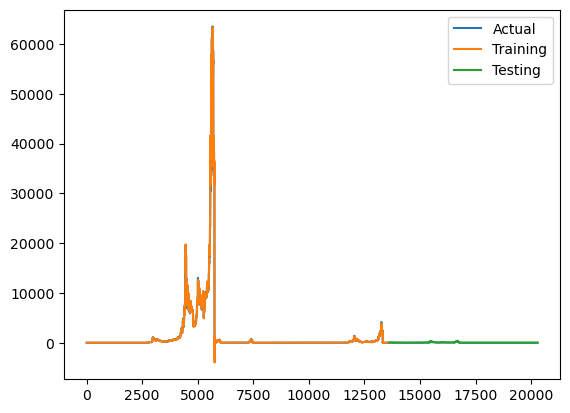

In [63]:
plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()